# Main Model

In this notebook, our goal is to make a better performing model by:
1. using a more complex algorithm; and
2. aggregating features from other files.

Our minimalistic model reached ROC AUC score of ~0.74, so our goal is to outperform that model. The models probability threshold will be tunned the same way as the minimalistic model: by using *calculate_profit* function from our helper.py to estimate total profits on the loans in the validation set.

Structure:
1. Data Preparation
2. Feature Aggregation with featuretools
3. Feature Selection
4. Hyperparameter Tunning
5. Threshold Analysis
6. Performance on Test set

LightGMB was selected as the ML algorithm due to following reasons:
* It performed better during the experimental stage
* It's able to handle categorical data and missing values, making it easy to use.
  * Furthermore, null values, especially when they are missing in a structural manner, can be informative.
* It's lighter and faster than XGBoost.


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
dir_path = "/content/drive/MyDrive/Colab Notebooks/LoanDefaults/"
sys.path.append(dir_path + "utils/")

In [3]:
!pip install optuna --quiet

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
)

import lightgbm as lgb
from lightgbm import early_stopping
import optuna
import joblib

import plot_functions as my
import helper as hl

For some reason, I'm getting display errors if I download featuretools libraries before displaying a pandas dataframe, so I have to do a trial run.

In [5]:
bureau = pd.read_csv(dir_path + "original_data/bureau.csv", nrows=10)
bureau.head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN


In [6]:
!pip install shap --quiet
!pip install featuretools --quiet
!pip install autofeatselect --quiet

import shap
import featuretools as ft
from autofeatselect import AutoFeatureSelect

In [7]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 125)

pd.set_option("display.float_format", lambda x: "%.3f" % x)

sns.set_style("white")

# Data Preparation

Our dataframes are already processed in the Data Cleaning notebook, so let's import them here.

## Main file

In [8]:
train = pd.read_pickle(dir_path + "data/train.pkl")
train["set"] = "train"
valid = pd.read_pickle(dir_path + "data/valid.pkl")
valid["set"] = "valid"
test = pd.read_pickle(dir_path + "data/test.pkl")
test["set"] = "test"

print(train.shape, valid.shape, test.shape)
loans = pd.concat([train, valid, test])

print(loans.shape)
del train, valid, test

(276759, 125) (15376, 125) (15376, 125)
(307511, 125)


In [9]:
loans.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMERGENCYSTATE_MODE_MISSING,DAYS_EMPLOYED_ANOMALY,set
234502,371646,False,Cash loans,F,False,True,0,180000.000,781920.000,28215.000,675000.000,Unaccompanied,Commercial associate,Higher education,Civil marriage,House / apartment,0.036,-13752,-4125.000,-638.000,-4548,NaN,True,True,False,True,True,False,Accountants,2.000,2,2,WEDNESDAY,11,False,True,True,False,True,True,Business Entity Type 3,NaN,0.504,0.356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.000,0.000,0.000,0.000,-105.000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000,0.000,0.000,0.000,0.000,1.000,True,False,train
34261,139700,False,Cash loans,F,True,True,1,202500.000,1006920.000,42790.500,900000.000,"Spouse, partner",Working,Higher education,Married,House / apartment,0.011,-10881,-3714.000,-142.000,-274,4.000,True,True,False,True,True,False,High skill tech staff,3.000,2,2,SATURDAY,10,False,False,False,True,False,True,Business Entity Type 3,NaN,0.324,NaN,0.088,0.048,0.982,0.755,0.031,0.080,0.035,0.458,0.042,0.046,0.071,0.076,0.000,0.000,0.089,0.050,0.982,0.765,0.032,0.081,0.035,0.458,0.042,0.048,0.078,0.080,0.000,0.000,0.088,0.048,0.982,0.758,0.031,0.080,0.035,0.458,0.042,0.047,0.073,0.078,0.000,0.000,org spec account,block of flats,0.077,"Stone, brick",False,0.000,0.000,0.000,0.000,-2257.000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000,0.000,0.000,0.000,0.000,0.000,False,False,train
265488,407492,False,Cash loans,F,False,False,0,36000.000,814041.000,23931.000,679500.000,Children,Pensioner,Secondary / secondary s

### Feature Engineering
We will also look try and engineer some additional features that would make sense based on the domain knowledge.

In [10]:
engineered_cols = [
    "INCOME_TO_CREDIT",
    "ANNUITY_TO_INCOME",
    "PAYMENT_RATE",
    "CREDIT_TO_GOODS",
    "EMPLOYMENT_RATE"
    ]

loans["INCOME_TO_CREDIT"] = loans["AMT_INCOME_TOTAL"] / loans["AMT_CREDIT"]
loans["ANNUITY_TO_INCOME"] = loans["AMT_ANNUITY"] / loans["AMT_INCOME_TOTAL"]
loans["PAYMENT_RATE"] = loans["AMT_ANNUITY"] / loans["AMT_CREDIT"]
loans["CREDIT_TO_GOODS"] = loans["AMT_CREDIT"] / loans["AMT_GOODS_PRICE"]

loans["EMPLOYMENT_RATE"] = loans["DAYS_EMPLOYED"] / (loans["DAYS_BIRTH"] + 18 * 365.25)

## Other files

In [11]:
prev = pd.read_csv(dir_path + "data/previous_application.csv")
inst_paym = pd.read_csv(dir_path + "data/installments_payments.csv")
pos_cash = pd.read_csv(dir_path + "data/POS_CASH_balance.csv")
credit = pd.read_csv(dir_path + "data/credit_card_balance.csv")

bureau = pd.read_csv(dir_path + "data/bureau.csv")
bureau_bal = pd.read_csv(dir_path + "data/bureau_balance.csv")

## Feature Aggregation
Featuretools is an open source framework for automated feature engineering. Since we have relational data, and we can't be sure which types of aggregations for which columns will be relevant - it's perfect for this task.

The downside to this is that we will have way too many features, a lot of them being correlated, so we will have to filter out a lot of them to make the model deployable. Furthermore, this requires us to move away from pipelines for data transformation, as we will be working in "entities" to connect the files through ID columns. This means that we are processing training, validation and test sets together. We should avoid data leakage as long as we don't aggregate values along the rows or across IDs.

In [12]:
es = ft.EntitySet(id="clients")
es = es.add_dataframe(dataframe_name="applications", dataframe=loans, index="SK_ID_CURR")

In [13]:
es = es.add_dataframe(dataframe_name="prev_loans", dataframe=prev, index="SK_ID_PREV")

es = es.add_dataframe(dataframe_name="inst_paym", dataframe=inst_paym, make_index=True, index="inst_index")
es = es.add_dataframe(dataframe_name="pos_cash", dataframe=pos_cash, make_index=True, index="pos_cash_index")
es = es.add_dataframe(dataframe_name="credit_card", dataframe=credit, make_index=True, index="credit_index")

es = es.add_dataframe(dataframe_name="bureau", dataframe=bureau, index="SK_ID_BUREAU")
es = es.add_dataframe(dataframe_name="bureau_bal", dataframe=bureau_bal, make_index=True, index="bureau_bal_index")

In [14]:
es = es.add_relationship("applications", "SK_ID_CURR", "prev_loans", "SK_ID_CURR")

es = es.add_relationship("prev_loans", "SK_ID_PREV", "inst_paym", "SK_ID_PREV")
es = es.add_relationship("prev_loans", "SK_ID_PREV", "pos_cash", "SK_ID_PREV")
es = es.add_relationship("prev_loans", "SK_ID_PREV", "credit_card", "SK_ID_PREV")

es = es.add_relationship("applications", "SK_ID_CURR", "bureau", "SK_ID_CURR")
es = es.add_relationship("bureau", "SK_ID_BUREAU", "bureau_bal", "SK_ID_BUREAU")

In [15]:
es

Entityset: clients
  DataFrames:
    applications [Rows: 307511, Columns: 130]
    prev_loans [Rows: 1661739, Columns: 23]
    inst_paym [Rows: 12861994, Columns: 10]
    pos_cash [Rows: 10001358, Columns: 9]
    credit_card [Rows: 3840312, Columns: 23]
    bureau [Rows: 1715020, Columns: 17]
    bureau_bal [Rows: 14102536, Columns: 6]
  Relationships:
    prev_loans.SK_ID_CURR -> applications.SK_ID_CURR
    inst_paym.SK_ID_PREV -> prev_loans.SK_ID_PREV
    pos_cash.SK_ID_PREV -> prev_loans.SK_ID_PREV
    credit_card.SK_ID_PREV -> prev_loans.SK_ID_PREV
    bureau.SK_ID_CURR -> applications.SK_ID_CURR
    bureau_bal.SK_ID_BUREAU -> bureau.SK_ID_BUREAU

In [16]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="applications",
    agg_primitives=["count", "mean", "min", "max", "variance"],
    max_depth=2,
)

feature_matrix.to_pickle(dir_path + "data/loans_agg.pkl")
feature_matrix.shape

(307511, 1163)

In [17]:
feature_matrix = pd.read_pickle(dir_path + "data/loans_agg.pkl")
print(feature_matrix.shape)

(307511, 1163)


In [18]:
feature_matrix = feature_matrix.reset_index()
print(feature_matrix.shape)
feature_matrix.head(3)

(307511, 1164)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMERGENCYSTATE_MODE_MISSING,DAYS_EMPLOYED_ANOMALY,set,INCOME_TO_CREDIT,ANNUITY_TO_INCOME,PAYMENT_RATE,CREDIT_TO_GOODS,EMPLOYMENT_RATE,COUNT(prev_loans),MAX(prev_loans.AMT_ANNUITY),MAX(prev_loans.AMT_APPLICATION),MAX(prev_loans.AMT_CREDIT),MAX(prev_loans.AMT_DOWN_PAYMENT),MAX(prev_loans.AMT_GOODS_PRICE),MAX(prev_loans.CNT_PAYMENT),MAX(prev_loans.DAYS_DECISION),MAX(prev_loans.DAYS_FIRST_DRAWING),MAX(prev_loans.DAYS_FIRST_DUE),MAX(prev_loans.DAYS_LAST_DUE),MAX(prev_loans.DAYS_LAST_DUE_1ST_VERSION),MAX(prev_loans.DAYS_TERMINATION),MAX(prev_loans.NAME_YIELD_GROUP),MAX(prev_loans.NFLAG_INSURED_ON_APPROVAL),MAX(prev_loans.NFLAG_LAST_APPL_IN_DAY),MAX(prev_loans.RATE_DOWN_PAYMENT),MAX(prev_loans.RATE_INTEREST_PRIMARY),MAX(prev_loans.RATE_INTEREST_PRIVILEGED),MAX(prev_loans.SELLERPLACE_AREA),MEAN(prev_loans.AMT_ANNUITY),MEAN(prev_loans.AMT_APPLICATION),MEAN(prev_loans.AMT_CREDIT),MEAN(prev_loans.AMT_DOWN_PAYMENT),MEAN(prev_loans.AMT_GOODS_PRICE),MEAN(prev_loans.CNT_PAYMENT),MEAN(prev_loans.DAYS_DECISION),MEAN(prev_loans.DAYS_FIRST_DRAWING),MEAN(prev_loans.DAYS_FIRST_DUE),MEAN(prev_loans.DAYS_LAST_DUE),MEAN(prev_loans.DAYS_LAST_DUE_1ST_VERSION),MEAN(prev_loans.DAYS_TERMINATION),MEAN(prev_loans.NAME_YIELD_GROUP),MEAN(prev_loans.NFLAG_INSURED_ON_APPROVAL),MEAN(prev_loans.NFLAG_LAST_APPL_IN_DAY),MEAN(prev_loans.RATE_DOWN_PAYMENT),MEAN(prev_loans.RATE_INTEREST_PRIMARY),MEAN(prev_loans.RATE_INTEREST_PRIVILEGED),MEAN(prev_loans.SELLERPLACE_AREA),MIN(prev_loans.AMT_ANNUITY),MIN(prev_loans.AMT_APPLICATION),MIN(prev_loans.AMT_CREDIT),MIN(prev_loans.AMT_DOWN_PAYMENT),MIN(prev_loans.AMT_GOODS_PRICE),MIN(prev_loans.CNT_PAYMENT),MIN(prev_loans.DAYS_DECISION),MIN(prev_loans.DAYS_FIRST_DRAWING),MIN(prev_loans.DAYS_FIRST_DUE),MIN(prev_loans.DAYS_LAST_DUE),MIN(prev_loans.DAYS_LAST_DUE_1ST_VERSIO

Since we have ID columns which are numeric, but should not hold any value when predicting, we need to drop them from the dataframe. Furthermore, we will be dropping columns with highly null values and single values using built in functions of the featuretools package.

In [19]:
id_cols = []
for col in feature_matrix:
    if "SK_ID_CURR" in col or "SK_ID_PREV" in col or "SK_ID_BUREAU" in col:
        if col != "SK_ID_CURR":
            id_cols.append(col)

print(id_cols)

feature_matrix.drop(columns=id_cols, inplace=True)
print(feature_matrix.shape)

['MAX(pos_cash.SK_ID_CURR)', 'MEAN(pos_cash.SK_ID_CURR)', 'MIN(pos_cash.SK_ID_CURR)', 'VARIANCE(pos_cash.SK_ID_CURR)', 'MAX(credit_card.SK_ID_CURR)', 'MEAN(credit_card.SK_ID_CURR)', 'MIN(credit_card.SK_ID_CURR)', 'VARIANCE(credit_card.SK_ID_CURR)', 'MAX(prev_loans.MEAN(credit_card.SK_ID_CURR))', 'MAX(prev_loans.MEAN(pos_cash.SK_ID_CURR))', 'MAX(prev_loans.MIN(credit_card.SK_ID_CURR))', 'MAX(prev_loans.MIN(pos_cash.SK_ID_CURR))', 'MAX(prev_loans.VARIANCE(credit_card.SK_ID_CURR))', 'MAX(prev_loans.VARIANCE(pos_cash.SK_ID_CURR))', 'MEAN(prev_loans.MAX(credit_card.SK_ID_CURR))', 'MEAN(prev_loans.MAX(pos_cash.SK_ID_CURR))', 'MEAN(prev_loans.MEAN(credit_card.SK_ID_CURR))', 'MEAN(prev_loans.MEAN(pos_cash.SK_ID_CURR))', 'MEAN(prev_loans.MIN(credit_card.SK_ID_CURR))', 'MEAN(prev_loans.MIN(pos_cash.SK_ID_CURR))', 'MEAN(prev_loans.VARIANCE(credit_card.SK_ID_CURR))', 'MEAN(prev_loans.VARIANCE(pos_cash.SK_ID_CURR))', 'MIN(prev_loans.MAX(credit_card.SK_ID_CURR))', 'MIN(prev_loans.MAX(pos_cash.SK_ID_

In [20]:
feature_matrix = ft.selection.remove_highly_null_features(feature_matrix)
print(feature_matrix.shape)

feature_matrix = ft.selection.remove_single_value_features(feature_matrix)
print(feature_matrix.shape)

(307511, 1026)
(307511, 1007)


Below, we are splitting the dataframe to train, test and validation sets with a function from our helper.py file.

In [21]:
X_train, X_valid, X_test, y_train, y_valid, y_test = hl.split_dataframe(feature_matrix)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(276759, 1004) (15376, 1004) (276759,) (15376,)


# Model Creation

We will begin by training our LightGBM binary classifier with all of the features and using the default parameters.

In [22]:
model = lgb.LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    random_state=42,
)

model.fit(
    X_train, y_train,
    eval_metric="auc",
)

hl.show_results(model, X_train, y_train, X_valid, y_valid)

[LightGBM] [Info] Number of positive: 22342, number of negative: 254417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.934348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192519
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

       False       0.96      0.74      0.84     14134
        True       0.19      0.69      0.30      1242

    accuracy                           0.73     15376
   macro avg       0.58      0.71      0.57     15376
weighted avg       0.90      0.73      0.79     15376

Train AUC: 0.8342
Valid AUC: 0.7849


<Figure size 800x600 with 0 Axes>

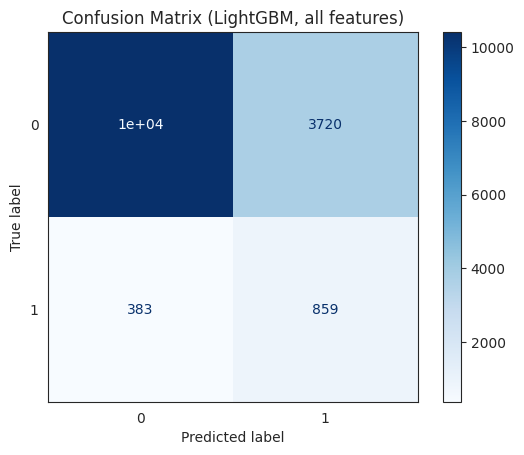

In [23]:
yhat = model.predict(X_valid)

plt.figure(figsize=(8, 6))
my.plot_confusion_matrix(y_valid, yhat, "LightGBM, all features")
plt.show()

As expected, the model performs much better with the majority class. Currently, we have ~10x more False Positives than we have False Negatives.

Looking at the ROC curve, the model does have more prediction power than our baseline model, but it isn't too impressive.

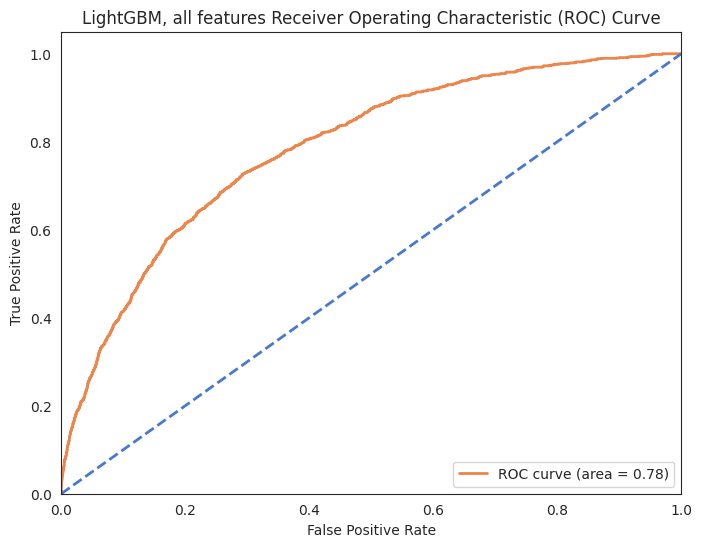

In [24]:
my.plot_roc_curve(model, X_valid, y_valid, "LightGBM, all features")
plt.show()

In [25]:
models = pd.read_csv(dir_path + "data/baseline_model.csv")
models.at[0, "name"] = "Logistic Regression"

models = hl.evaluate_model(model, "All features", X_valid, y_valid, df=models)
models

,name,features_count,accuracy,precision,recall,f1_score,auc,inference_time,disk_space
0,Logistic Regression,35,0.686,0.157,0.658,0.253,0.740,0.011,2283
0,All features,1004,0.733,0.188,0.692,0.295,0.785,0.454,443622


## Feature Selection

We will first remove all the features that don't have any gain in the Light GBM Feature Importance. Then we will use AutoFeatureSelection with RFECV (Recursive Feature Selection with Cross Validation).

In [26]:
light_gbm_ft_importance = pd.DataFrame({"feature": X_train.columns, "importance": model.feature_importances_})
light_gbm_ft_importance.sort_values(by="importance", ascending=False).head(10)
zero_importance_cols = light_gbm_ft_importance[light_gbm_ft_importance["importance"] == 0].feature.to_list()
len(zero_importance_cols)

545

In [27]:
X_train, X_valid, X_test, y_train, y_valid, y_test = hl.split_dataframe(feature_matrix.drop(columns=zero_importance_cols))
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(276759, 459) (15376, 459) (276759,) (15376,)


In [28]:
model2 = lgb.LGBMClassifier(
    objective='binary',
    class_weight="balanced",
    random_state=42,
)

model2.fit(
    X_train, y_train,
    eval_metric="auc",
)

yhat = model2.predict_proba(X_valid)[:, 1]
print(f"\nROC AUC for Validation set: {roc_auc_score(y_valid, yhat):.4f}")

[LightGBM] [Info] Number of positive: 22342, number of negative: 254417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.009952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102295
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 459
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

ROC AUC for Validation set: 0.7849


In [29]:
models = hl.evaluate_model(model2, "No 0 Features", X_valid, y_valid, df=models)
models

,name,features_count,accuracy,precision,recall,f1_score,auc,inference_time,disk_space
0,Logistic Regression,35,0.686,0.157,0.658,0.253,0.740,0.011,2283
0,All features,1004,0.733,0.188,0.692,0.295,0.785,0.454,443622
0,No 0 Features,459,0.733,0.188,0.692,0.295,0.785,0.273,411046


Dropping more than half the features did not change our performance. Let's continued with automatic feature selection.

In [30]:
cat_cols = []

for column in X_train.columns:
    if not pd.api.types.is_numeric_dtype(X_train[column]) or hl.is_binary(X_train[column]):
        cat_cols.append(column)

num_cols = list(set(X_train.columns) - set(cat_cols))
print(len(num_cols), len(cat_cols))

440 19


In [31]:
"""
feat_selector = AutoFeatureSelect(modeling_type='classification',
                                  X_train=X_train,
                                  y_train=y_train,
                                  X_test=X_valid,
                                  y_test=y_valid,
                                  numeric_columns=num_cols,
                                  categorical_columns=cat_cols,
                                  seed=24)

corr_features = feat_selector.calculate_correlated_features(static_features=None,
                                                            num_threshold=0.9,
                                                            cat_threshold=0.9)

feat_selector.drop_correlated_features()

final_importance_df = feat_selector.apply_feature_selection(selection_methods=['lgbm', 'rfecv')
"""

"\nfeat_selector = AutoFeatureSelect(modeling_type='classification',\n                                  X_train=X_train,\n                                  y_train=y_train,\n                                  X_test=X_valid,\n                                  y_test=y_valid,\n                                  numeric_columns=num_cols,\n                                  categorical_columns=cat_cols,\n                                  seed=24)\n\ncorr_features = feat_selector.calculate_correlated_features(static_features=None,\n                                                            num_threshold=0.9,\n                                                            cat_threshold=0.9)\n\nfeat_selector.drop_correlated_features()\n\nfinal_importance_df = feat_selector.apply_feature_selection(selection_methods=['lgbm', 'rfecv')\n"

In [32]:
#final_importance_df.to_pickle(dir_path + "data/final_importances.pkl")

In [33]:
final_importance_df = pd.read_pickle(dir_path + "data/final_importances.pkl")

In [34]:
top_ranking_features = final_importance_df[final_importance_df["rfecv_rankings"]==1]
print(len(top_ranking_features))
top_ranking_features.head()

162


,feature,lgbm_importance,rfecv_rankings
0,EXT_SOURCE_3,33942.246,1
1,EXT_SOURCE_2,28954.149,1
2,ORGANIZATION_TYPE,10318.054,1
3,EXT_SOURCE_1,9186.672,1
4,PAYMENT_RATE,5991.979,1


In [35]:
new_features = top_ranking_features.feature.to_list()

In [36]:
X_train, X_valid, X_test, y_train, y_valid, y_test = hl.split_dataframe(feature_matrix[new_features + ["SK_ID_CURR", "TARGET", "set"]])
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(276759, 162) (15376, 162) (276759,) (15376,)


In [37]:
model3 = lgb.LGBMClassifier(
    objective='binary',
    class_weight="balanced",
    random_state=42,
)

model3.fit(
    X_train, y_train,
    eval_metric="auc",
)

hl.show_results(model3, X_train, y_train, X_valid, y_valid)

[LightGBM] [Info] Number of positive: 22342, number of negative: 254417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36169
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 162
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

       False       0.96      0.73      0.83     14134
        True       0.18      0.69      0.29      1242

    accuracy                           0.73     15376
   macro avg       0.57      0.71      0.56     15376
weighted avg       0.90      0.73      0.79     15376

Train AUC: 0.8309
Valid AUC: 0.7844


In [38]:
models = hl.evaluate_model(model3, "RFECV Rank 1", X_valid, y_valid, df=models)
models

,name,features_count,accuracy,precision,recall,f1_score,auc,inference_time,disk_space
0,Logistic Regression,35,0.686,0.157,0.658,0.253,0.740,0.011,2283
0,All features,1004,0.733,0.188,0.692,0.295,0.785,0.454,443622
0,No 0 Features,459,0.733,0.188,0.692,0.295,0.785,0.273,411046
0,RFECV Rank 1,162,0.728,0.184,0.687,0.290,0.784,0.177,379350


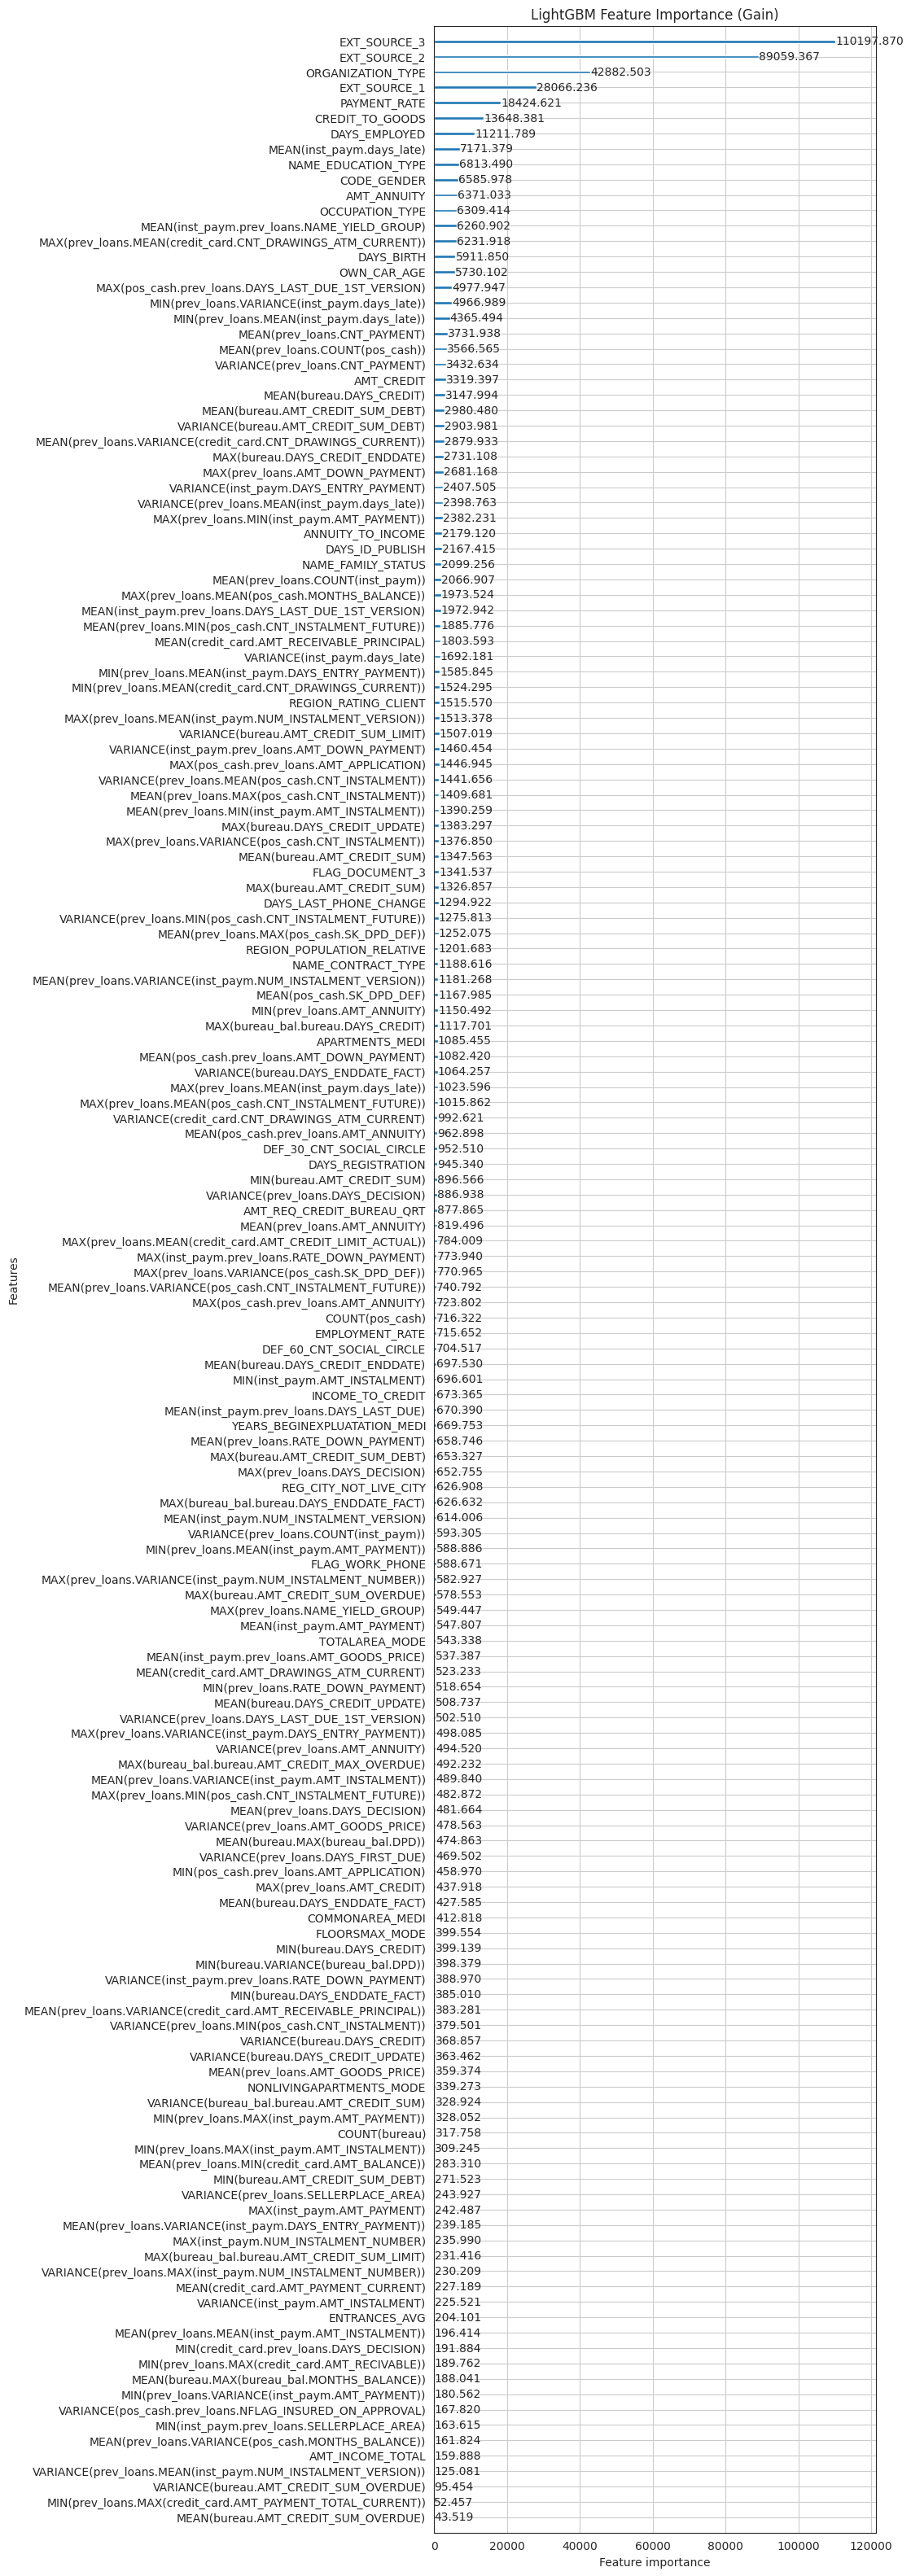

In [39]:
lgb.plot_importance(model3, importance_type="gain", figsize=(7,40), title="LightGBM Feature Importance (Gain)")
plt.show()

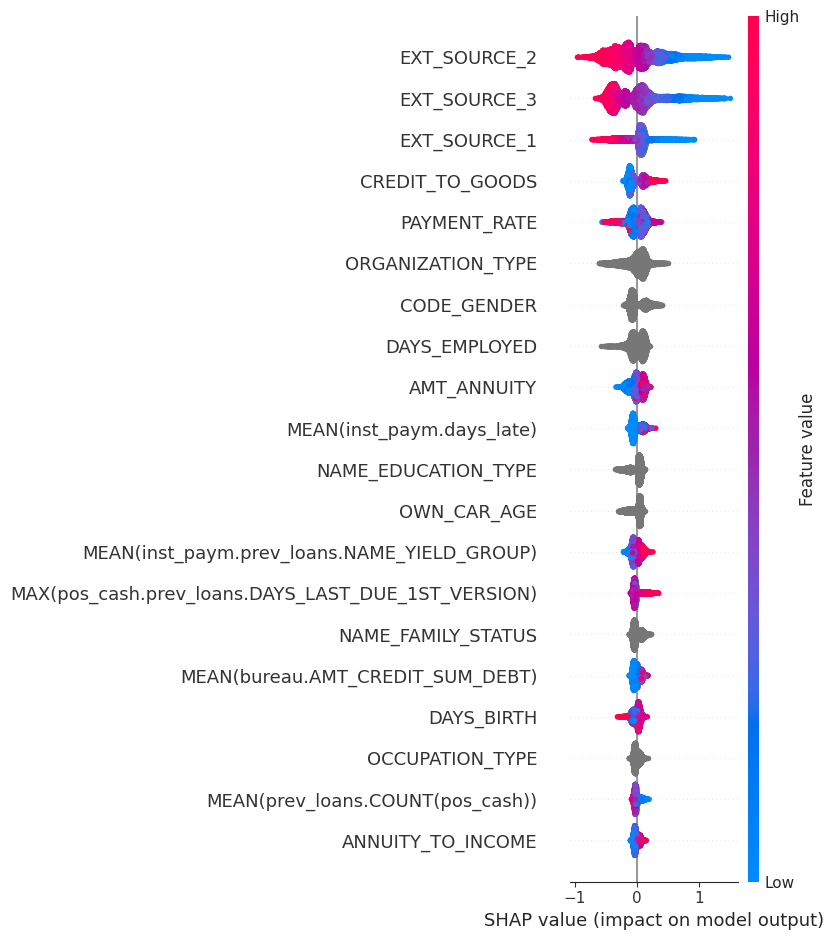

In [40]:
explainer = shap.TreeExplainer(model3)
shap_values = explainer(X_valid)

shap.summary_plot(shap_values, X_valid)

Looking at Feature importance: the most important features are features from the original loan applications, EXT_SOURCE features especially.

Futhermore, I'm glad to see that some of the features we engineered during data cleaning also made the list in the top20 features based on SHAP values:
* CREDIT_TO_GOODS
* PAYMENT_RATE
* days_late (from installment payments)
* ANNUITY_TO_INCOME

In [41]:
def assign_feature_file(col):
    if "bureau_bal." in col:
        return "Bureau Balance"

    elif "bureau." in col:
        return "Bureau"

    elif "inst_paym." in col:
        return "Instalment"

    elif "credit_card." in col:
        return "Credit Card"

    elif "pos_cash." in col:
        return "POS Cash"

    elif "prev_loans." in col:
        return "Previous"

    else:
        return "Current"

In [42]:
feature_df = final_importance_df[final_importance_df["rfecv_rankings"]==1].copy()

feature_df["source"] = feature_df["feature"].apply(assign_feature_file)
feature_df.head(10)

,feature,lgbm_importance,rfecv_rankings,source
0,EXT_SOURCE_3,33942.246,1,Current
1,EXT_SOURCE_2,28954.149,1,Current
2,ORGANIZATION_TYPE,10318.054,1,Current
3,EXT_SOURCE_1,9186.672,1,Current
4,PAYMENT_RATE,5991.979,1,Current
5,CREDIT_TO_GOODS,4601.582,1,Current
6,DAYS_EMPLOYED,3615.900,1,Current
7,AMT_ANNUITY,2295.417,1,Current
8,MAX(prev_loans.MEAN(credit_card.CNT_DRAWINGS_A...,2195.047,1,Credit Card
9,OCCUPATION_TYPE,2008.696,1,Current


In [43]:
stats_df = feature_df.groupby("source").agg({"lgbm_importance": ["size", "mean", "median", "min", "max"]})
stats_df

lgbm_importance                                   
                          size     mean  median     min       max
source                                                           
Bureau                      22  478.710 353.270 114.743  1307.317
Bureau Balance               8  229.155 186.208  56.845   589.253
Credit Card                 13  497.204 257.140 118.886  2195.047
Current                     40 2957.291 444.100  72.922 33942.246
Instalment                  37  451.290 221.899  33.070  1861.334
POS Cash                    21  442.894 423.983 109.400  1439.087
Previous                    21  403.530 215.506 108.575  1451.276

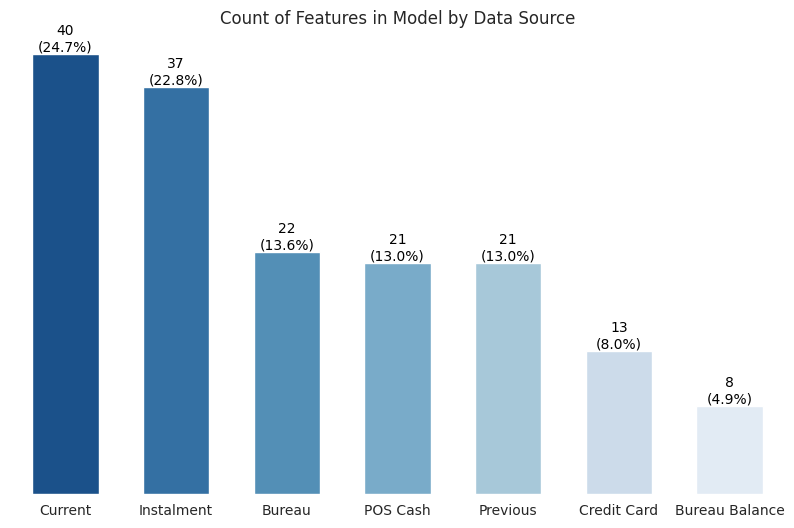

In [44]:
counts_df = stats_df["lgbm_importance"]["size"].reset_index().sort_values(by="size", ascending=False)

plt.figure(figsize=(10, 6))
my.plot_barchart(counts_df)
plt.title("Count of Features in Model by Data Source")
plt.show()

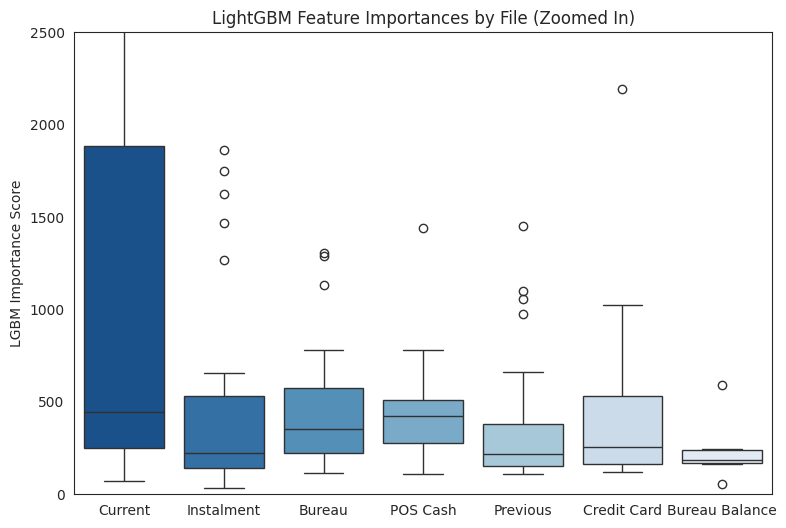

In [45]:
plt.figure(figsize=(9, 6))
sns.boxplot(data=feature_df, x="source", y="lgbm_importance", palette="Blues_r",
            order=counts_df["source"].to_list())
plt.ylim(0, 2500)

plt.title("LightGBM Feature Importances by File (Zoomed In)")
plt.xlabel("")
plt.ylabel("LGBM Importance Score")

plt.show()

## Hyperparameter Tunning
We will use Optuna as an efficient solution for the task.

In [46]:
def objective(trial):
    param = {
        'objective': 'binary',
        'class_weight': "balanced",
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 500),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = lgb.LGBMClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
              callbacks=[early_stopping(stopping_rounds=100, verbose=False)])

    preds = model.predict_proba(X_valid)[:, 1]

    auc = roc_auc_score(y_valid, preds)

    return auc

In [47]:
"""
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=120, n_jobs=-1)

best_params = study.best_params
print("Best params:", best_params)

best_score = study.best_value
print("Best score:", best_score)
"""

'\nstudy = optuna.create_study(direction="maximize")\nstudy.optimize(objective, n_trials=120, n_jobs=-1)\n\nbest_params = study.best_params\nprint("Best params:", best_params)\n\nbest_score = study.best_value\nprint("Best score:", best_score)\n'

Now let's see how our tunned model performs.

In [48]:
best_params = {
    "lambda_l1": 3.3957800111083767,
    "lambda_l2": 0.05615603279660858,
    "num_leaves": 37,
    "feature_fraction": 0.5218431247765575,
    "bagging_fraction": 0.9675885741363137,
    "bagging_freq": 11,
    "min_child_samples": 99
    }

In [49]:
model_tunned = lgb.LGBMClassifier(
    **best_params,
    class_weight="balanced",
    verbose=-1
)

model_tunned.fit(
    X_train, y_train,
)

yhat_valid = model_tunned.predict(X_valid)
yhat_valid_proba = model_tunned.predict_proba(X_valid)[:, 1]

hl.show_results(model_tunned, X_train, y_train, X_valid, y_valid)

              precision    recall  f1-score   support

       False       0.96      0.73      0.83     14134
        True       0.19      0.69      0.29      1242

    accuracy                           0.73     15376
   macro avg       0.58      0.71      0.56     15376
weighted avg       0.90      0.73      0.79     15376

Train AUC: 0.8333
Valid AUC: 0.7867


In [50]:
models = hl.evaluate_model(model_tunned, "Tunned", X_valid, y_valid, df=models)
models.sort_values(by="auc", ascending=False)

,name,features_count,accuracy,precision,recall,f1_score,auc,inference_time,disk_space
0,Tunned,162,0.729,0.186,0.694,0.293,0.787,0.202,443622
0,All features,1004,0.733,0.188,0.692,0.295,0.785,0.454,443622
0,No 0 Features,459,0.733,0.188,0.692,0.295,0.785,0.273,411046
0,RFECV Rank 1,162,0.728,0.184,0.687,0.290,0.784,0.177,379350
0,Logistic Regression,35,0.686,0.157,0.658,0.253,0.740,0.011,2283


Hyperparameter tunning increased our AUC by ~0.0034, and differences between training AUC and Validation AUC also reduced, so the model is less likely to be overfitting.

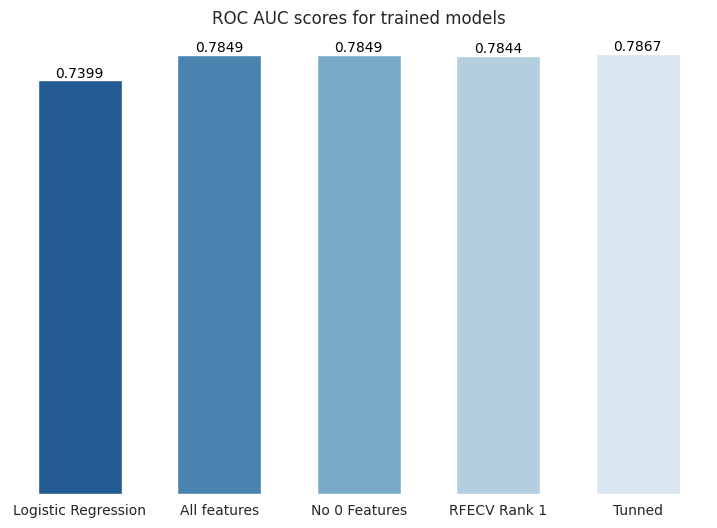

In [51]:
auc_df = models[["name", "auc"]]

plt.figure(figsize=(9, 6))
my.plot_barchart(auc_df, decimals=4, percent=False, order=False)
plt.title("ROC AUC scores for trained models")

plt.show()

In the barchart above, we see the progress of ROC AUC score through iteration. Only the first model uses Logistic Regression. The remaining models are all LightGBM models. Moving towards LightGBM model and adding additional files improves our model significantly. However, the remaining improvements are very much marginal.

Now, let's continue by optimizing the threshold for our business objectives.

## Threshold Analysis

As in Minimalistic Model notebook, we will tune our model according to our assumed rate of returns and loss given default.

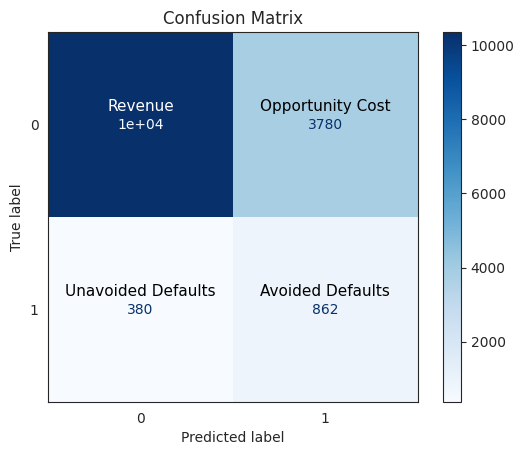

In [52]:
cm = confusion_matrix(y_valid, yhat_valid)

cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

labels = ["Revenue", "Opportunity Cost", "Unavoided Defaults", "Avoided Defaults"]

def get_text_color(value, max_val):
    "Function to determine text color based on the background color"
    if value / max_val > 0.5:
        return "white"
    else:
        return "black"


max_val = cm.max()
for i in range(2):
    for j in range(2):
        color = get_text_color(cm[i, j], max_val)
        plt.text(j, i - 0.1, f"{labels[i*2 + j]}", ha="center", va="center",
                 color=color, fontsize=11 )

plt.show()

In [53]:
sns.set_style()

In [54]:
y_valid_proba = model_tunned.predict_proba(X_valid)[:, 1]

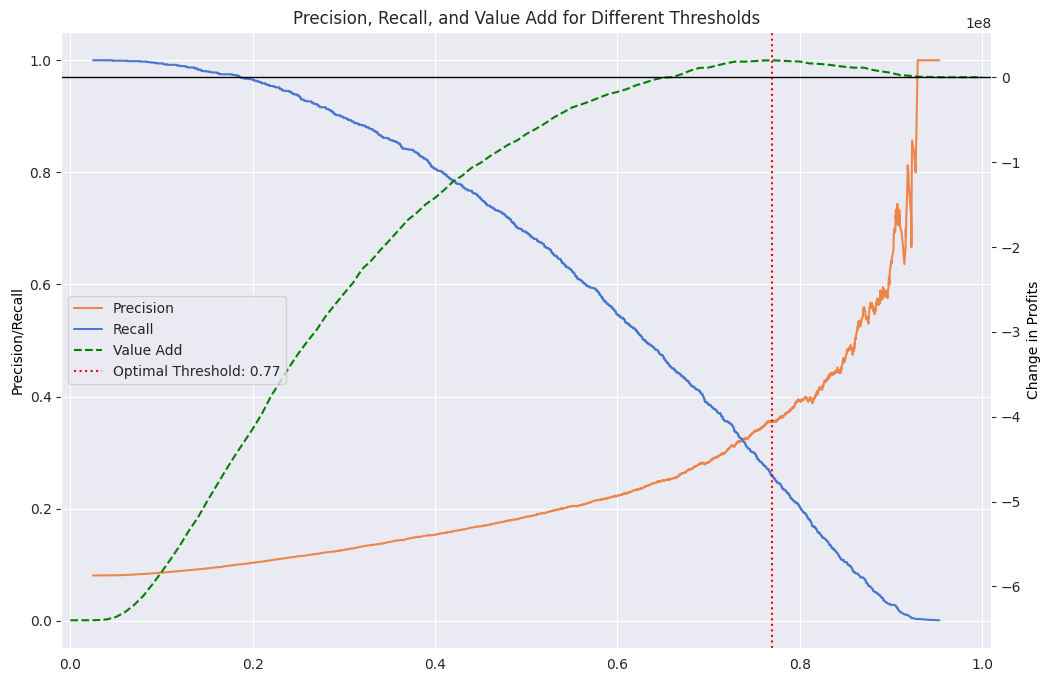

In [55]:
optimal_threshold, max_value_add, thresholds, value_adds = hl.find_optimal_threshold(X_valid, y_valid, yhat_valid_proba)

precision, recall, pr_thresholds = precision_recall_curve(y_valid, yhat_valid_proba)

sns.set_style("darkgrid")

plt.figure(figsize=(12, 8))

plt.plot(pr_thresholds, precision[:-1], "#ee854a", label="Precision")
plt.plot(pr_thresholds, recall[:-1], "#4878d0", label="Recall")
plt.axvline(x=optimal_threshold, color="red", linestyle=":", label=f"Optimal Threshold: {optimal_threshold:.2f}")
plt.ylabel("Precision/Recall", color="black")

plt2 = plt.gca().twinx()
plt2.plot(thresholds, value_adds, "g--", label="Value Add")
plt2.axhline(y=0, color="black", linestyle="-", linewidth=1)
plt2.set_ylabel("Change in Profits", color="black")

plt.xlim(-0.01, 1.01)
plt.xlabel("Threshold")
plt.title("Precision, Recall, and Value Add for Different Thresholds")

plt.grid(True, axis="y")
plt2.grid(False)

legend_elements = [
    Line2D([0], [0], color="#ee854a", linestyle="-", label="Precision"),
    Line2D([0], [0], color="#4878d0", linestyle="-", label="Recall"),
    Line2D([0], [0], color="g", linestyle="--", label="Value Add"),
    Line2D([0], [0], color="r", linestyle=":", label=f"Optimal Threshold: {optimal_threshold:.2f}")
]

plt.legend(handles=legend_elements, loc="center left")

plt.show()

Looking at the Precision-Recall chart above, based on our assumptions and calculations using the *calculate_profit* function it seams that we maximize value added with decision threshold of 0.77.

In [56]:
yhat_valid_proba = model_tunned.predict_proba(X_valid)[:, 1]
yhat_valid_new = (yhat_valid_proba >= optimal_threshold)

hl.calculate_profit(X_valid, y_valid, yhat_valid_new)

{'name': '',
 'total_revenue': 820593180.45,
 'total_loss': 160702878.15,
 'total_profit': 659890302.3000001,
 'opportunity_cost': 29451181.950000003,
 'avoided_loss': 49440650.4,
 'value_add': 19989468.449999996,
 'avg_unit_value_saved': 1300.043473595213,
 'avg_unit_revenue': 60542.5099933599,
 'avg_unit_profit': 53368.44305736213,
 'avg_unit_loss': 174487.3812703583}

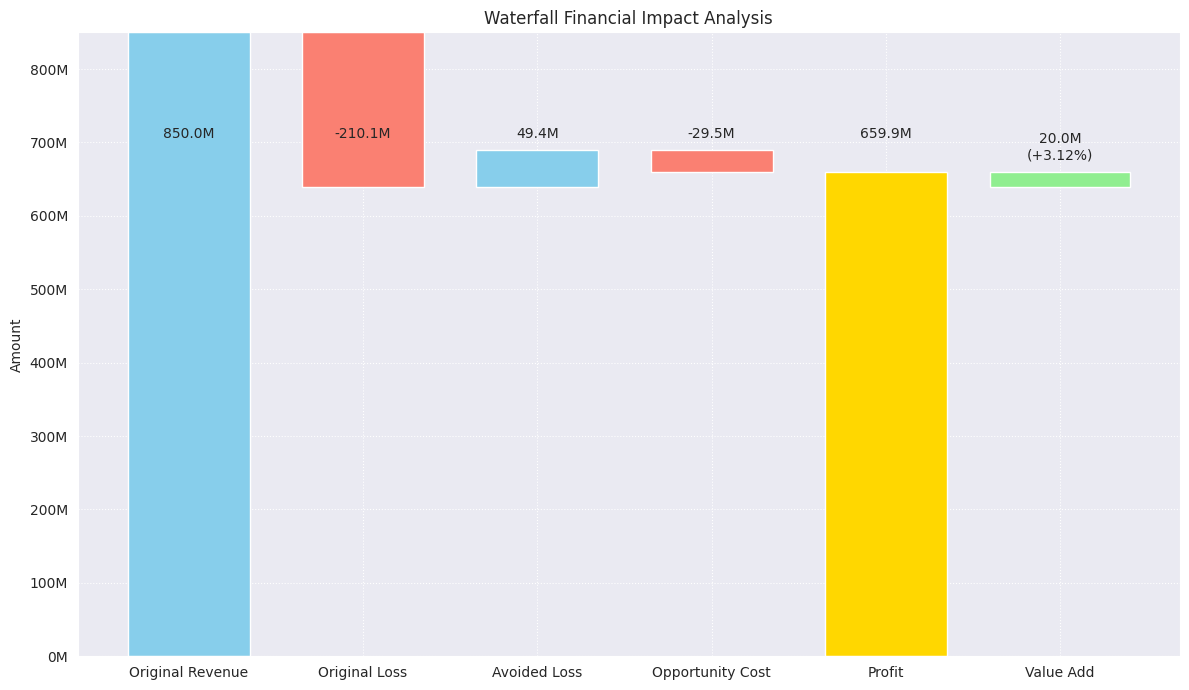

In [57]:
original_case = hl.calculate_profit(X_valid, y_valid, [False] * len(y_valid))
new_case = hl.calculate_profit(X_valid, y_valid, yhat_valid_new)

org_revenue  = original_case["total_revenue"]
org_loss = -original_case["total_loss"]
avoided_loss = new_case["avoided_loss"]
opportunity_cost = -new_case["opportunity_cost"]

increments = [org_revenue, org_loss, avoided_loss, opportunity_cost]
categories = ["Original Revenue", "Original Loss", "Avoided Loss", "Opportunity Cost"]

my.waterfall_chart(increments, categories)

With this model and selected threshold, we are able to increase estimated profits by ~3.15%. Although it does not seem like a lot, for a mature business where profits and margins are already close to optimal, and the sheer volume of money is large - small percentages can make significant changes.

## Performance on Test set

Test ROC AUC: 0.7839



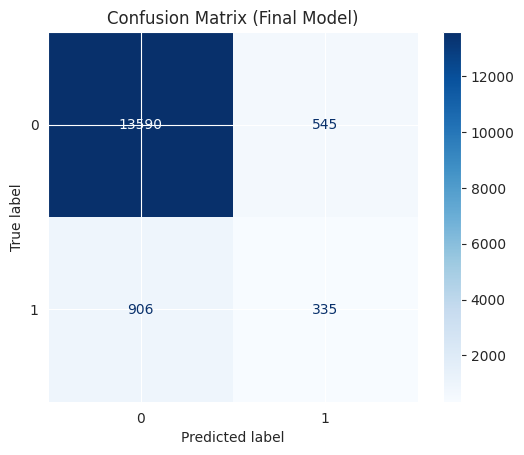

In [58]:
yhat_test_proba = model_tunned.predict_proba(X_test)[:, 1]
yhat_test = (yhat_test_proba >= optimal_threshold)

test_auc = roc_auc_score(y_test, yhat_test_proba)
print(f"Test ROC AUC: {test_auc:.4f}\n")

my.plot_confusion_matrix(y_test, yhat_test, "Final Model")
plt.show()

The model reaches a very similar ROC AUC score for the test set as for training and validation sets, so it doesn't seem to be overfitting. We are able to catch around > 300 defaulted loans (25% of total defaulted loans) and miss-classify almost < 500 good loans as defaulted. However, according to our threshold analysis, this is an economic tradeoff.

In [65]:
sns.set_style("white")

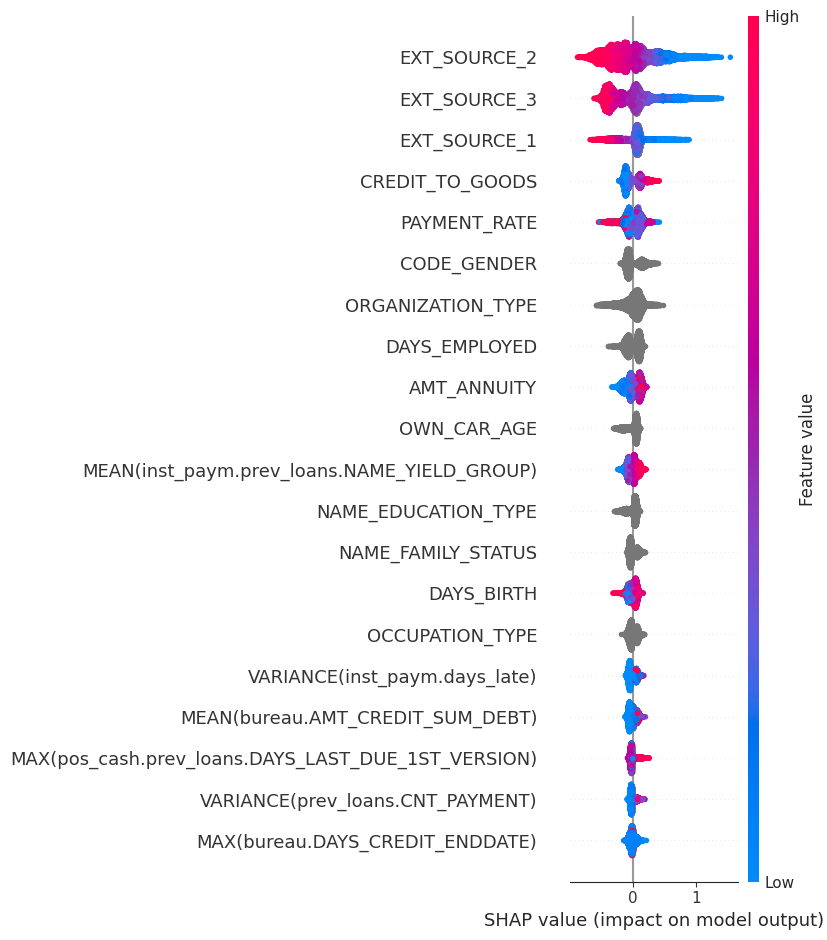

In [66]:
explainer = shap.TreeExplainer(model_tunned)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

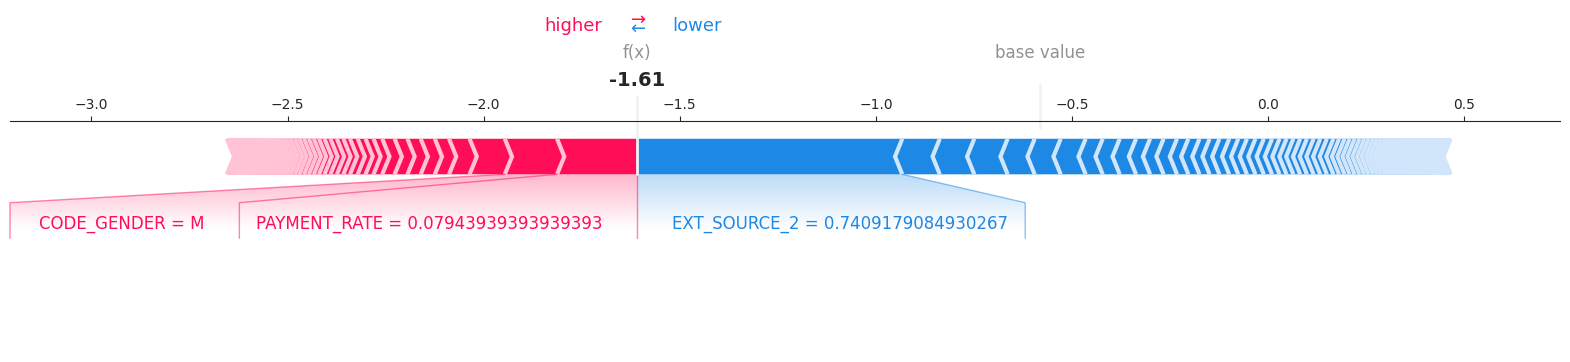

In [67]:
n = 0

sample_row = X_test.iloc[n : n+1]

shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[n].values,
    features=sample_row.astype(str),
    feature_names=sample_row.columns.to_list(),
    matplotlib=True
)

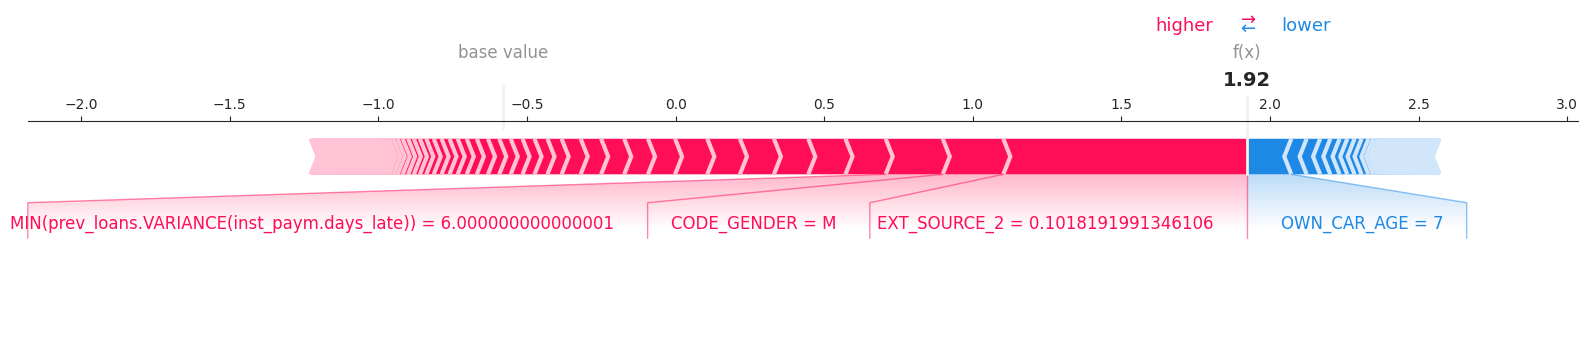

In [68]:
n = 99

sample_row = X_test.iloc[n : n+1]

shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[n].values,
    features=sample_row.astype(str),
    feature_names=sample_row.columns.to_list(),
    matplotlib=True
)

In [62]:
joblib.dump(model_tunned, dir_path + "model_files/" + "final_model.joblib")

['/content/drive/MyDrive/Colab Notebooks/LoanDefaults/model_files/final_model.joblib']

In [63]:
X_valid.to_pickle(dir_path + "data/final_valid.pkl")

In [64]:
dtypes = X_valid.dtypes

dtypes.to_pickle(dir_path + "data/dtypes.pkl")